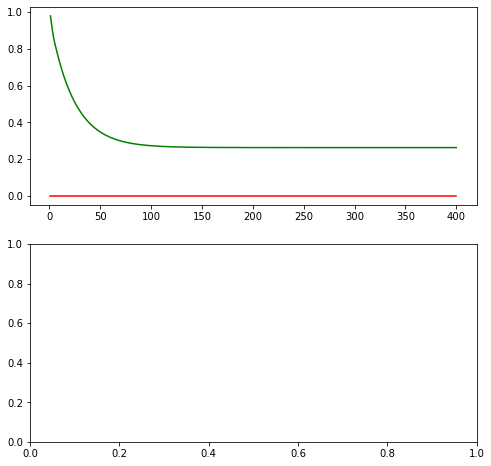

In [95]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The desired trajectory for the 
# robot is the x-axis. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau * crosstrack_error
#
# You'll only need to modify the `run` function at the bottom.
# ------------
 
import random
import numpy as np
import matplotlib.pyplot as plt

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

    
## P controller ###################################################################
############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run


#robot = Robot()
#robot.set(0.0, 1.0, 0.0)


# def run(robot, tau, n=100, speed=1.0):
#     x_trajectory = []
#     y_trajectory = []
#     # TODO: your code here
#     for i in range(n):
#         CTE = robot.y
#         steer =  -tau * CTE
#         robot.move(steer,speed)
#         x_trajectory.append(robot.x)
#         y_trajectory.append(robot.y)
#     return x_trajectory, y_trajectory
    
# x_trajectory, y_trajectory = run(robot,0.5)
# n = len(x_trajectory)

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
# ax1.plot(x_trajectory, y_trajectory, 'g', label='P controller')
# ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

#########################################################################################

####### the PD controller #################################################################

robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(6.0/180*math.pi)

def run(robot, tau_p, tau_d, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    CTE_last = 0
    for i in range(n):
        CTE_current = robot.y
        steer = -tau_p * CTE_current -tau_d*(CTE_current - CTE_last)
        robot.move(steer,speed)
        CTE_last = CTE_current
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory
    
x_trajectory, y_trajectory = run(robot, 0.4, 10.0,n = 400)
n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PD controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')

#####################################################################################################


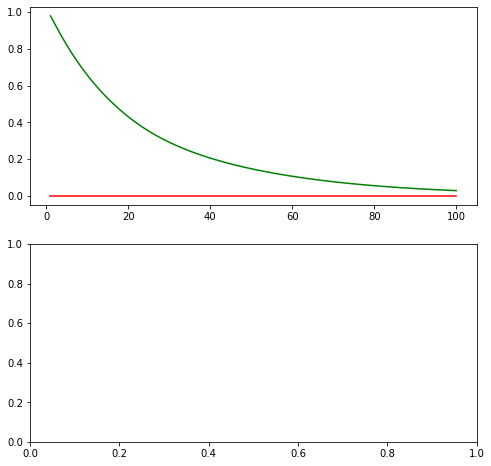

In [105]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Only modify code at the bottom! Look for the TODO.
# ------------

import random
import numpy as np
import matplotlib.pyplot as plt
import math

# ------------------------------------------------
# 
# this is the Robot class
#

class Robot(object):
    def __init__(self, length=20.0):
        """
        Creates robot and initializes location/orientation to 0, 0, 0.
        """
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    def set(self, x, y, orientation):
        """
        Sets a robot coordinate.
        """
        self.x = x
        self.y = y
        self.orientation = orientation % (2.0 * np.pi)

    def set_noise(self, steering_noise, distance_noise):
        """
        Sets the noise parameters.
        """
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = steering_noise
        self.distance_noise = distance_noise

    def set_steering_drift(self, drift):
        """
        Sets the systematical steering drift parameter
        """
        self.steering_drift = drift

    def move(self, steering, distance, tolerance=0.001, max_steering_angle=np.pi / 4.0):
        """
        steering = front wheel steering angle, limited by max_steering_angle
        distance = total distance driven, most be non-negative
        """
        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = np.tan(steering2) * distance2 / self.length

        if abs(turn) < tolerance:
            # approximate by straight line motion
            self.x += distance2 * np.cos(self.orientation)
            self.y += distance2 * np.sin(self.orientation)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
        else:
            # approximate bicycle model for motion
            radius = distance2 / turn
            cx = self.x - (np.sin(self.orientation) * radius)
            cy = self.y + (np.cos(self.orientation) * radius)
            self.orientation = (self.orientation + turn) % (2.0 * np.pi)
            self.x = cx + (np.sin(self.orientation) * radius)
            self.y = cy - (np.cos(self.orientation) * radius)

    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]' % (self.x, self.y, self.orientation)

############## ADD / MODIFY CODE BELOW ####################
# ------------------------------------------------------------------------
#
# run - does a single control run

robot = Robot()
robot.set(0, 1, 0)
robot.set_steering_drift(6/180*math.pi)

def run(robot, tau_p, tau_d, tau_i, n=100, speed=1.0):
    x_trajectory = []
    y_trajectory = []
    # TODO: your code here
    CTE_last = 0
    CTE_sum = 0
    
    for i in range(n):
        CTE = robot.y
        steer = -tau_p*CTE -tau_d*(CTE-CTE_last) -tau_i*CTE_sum
        robot.move(steer,speed)
        CTE_last = CTE
        CTE_sum+=CTE
        x_trajectory.append(robot.x)
        y_trajectory.append(robot.y)
    return x_trajectory, y_trajectory


x_trajectory, y_trajectory = run(robot, 0.2, 3.0, 0.004)
n = len(x_trajectory)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(x_trajectory, y_trajectory, 'g', label='PID controller')
ax1.plot(x_trajectory, np.zeros(n), 'r', label='reference')
